In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd



df = pd.read_csv("Brazil_Data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162825 entries, 0 to 162824
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   quadkey       162825 non-null  float64
 1   avg_d_kbps    162825 non-null  float64
 2   avg_u_kbps    162825 non-null  float64
 3   avg_lat_ms    162825 non-null  float64
 4   tests         162825 non-null  float64
 5   devices       162825 non-null  float64
 6   longitude     162825 non-null  float64
 7   latitude      162825 non-null  float64
 8   radiance_avg  162825 non-null  float64
dtypes: float64(9)
memory usage: 11.2 MB


In [57]:
# Define thresholds for "digital dark zones"
low_radiance_threshold = df['radiance_avg'].quantile(0.25)
low_speed_threshold = df['avg_d_kbps'].quantile(0.25)

# Add a column to classify "digital dark zones"
df['digital_dark_zone'] = (df['radiance_avg'] <= low_radiance_threshold) & (df['avg_d_kbps'] <= low_speed_threshold)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162825 entries, 0 to 162824
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   quadkey            162825 non-null  float64
 1   avg_d_kbps         162825 non-null  float64
 2   avg_u_kbps         162825 non-null  float64
 3   avg_lat_ms         162825 non-null  float64
 4   tests              162825 non-null  float64
 5   devices            162825 non-null  float64
 6   longitude          162825 non-null  float64
 7   latitude           162825 non-null  float64
 8   radiance_avg       162825 non-null  float64
 9   digital_dark_zone  162825 non-null  bool   
dtypes: bool(1), float64(9)
memory usage: 11.3 MB


C:\Users\alsammany\AppData\Local\Temp\ipykernel_13668\1218189265.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(x=df['longitude'], y=df['latitude'], ax=ax, cmap='coolwarm', shade=True, bw_adjust=0.5)


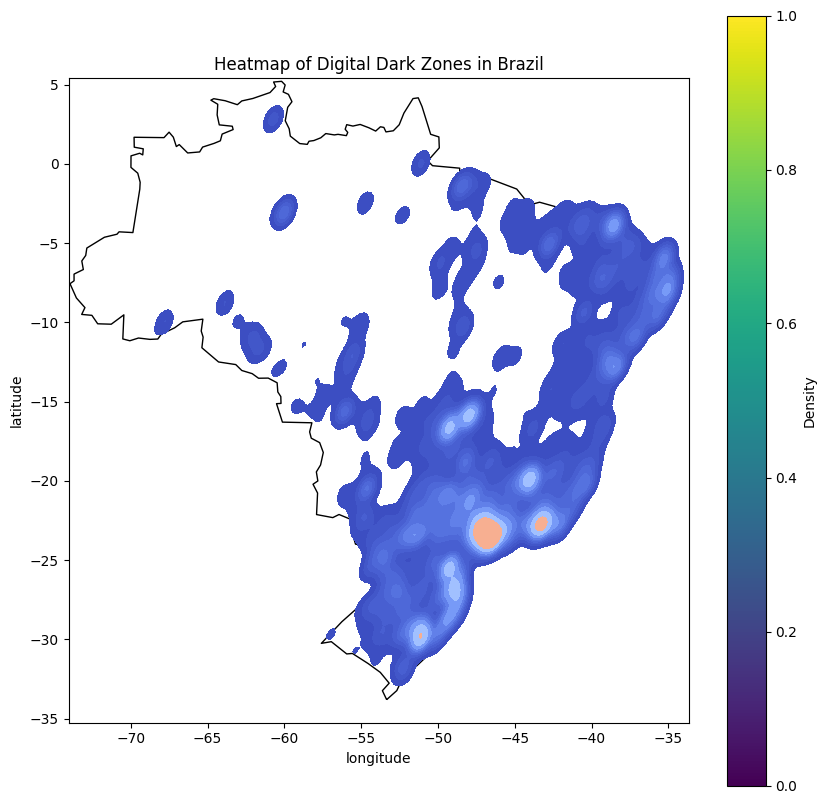

In [58]:
#1.	Heatmap


world = gpd.read_file("../110m_cultural/ne_110m_admin_0_countries.shp")
brazil = world[world['NAME'] == 'Brazil']

# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
brazil.plot(ax=ax, color='white', edgecolor='black')

# Create a heatmap using seaborn
kde = sns.kdeplot(x=df['longitude'], y=df['latitude'], ax=ax, cmap='coolwarm', shade=True, bw_adjust=0.5)
plt.title('Heatmap of Digital Dark Zones in Brazil')

# Add a colorbar
cbar = plt.colorbar(kde.collections[0], ax=ax, orientation='vertical')
cbar.set_label('Density')

plt.show()  

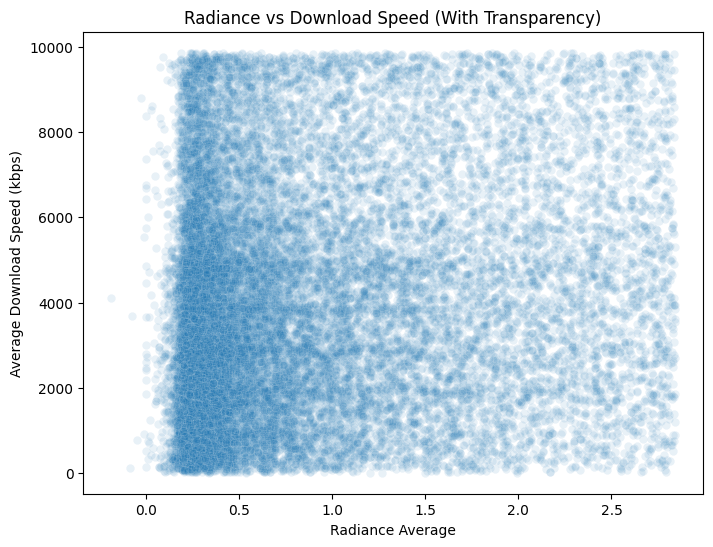

In [59]:
#2.	Scatter Plot

low_activity_regions = df[df['digital_dark_zone'] == True]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=low_activity_regions['radiance_avg'],
    y=low_activity_regions['avg_d_kbps'],
    alpha=0.1  # Lower alpha for transparency
)
plt.title("Radiance vs Download Speed (With Transparency)")
plt.xlabel("Radiance Average")
plt.ylabel("Average Download Speed (kbps)")
plt.show()


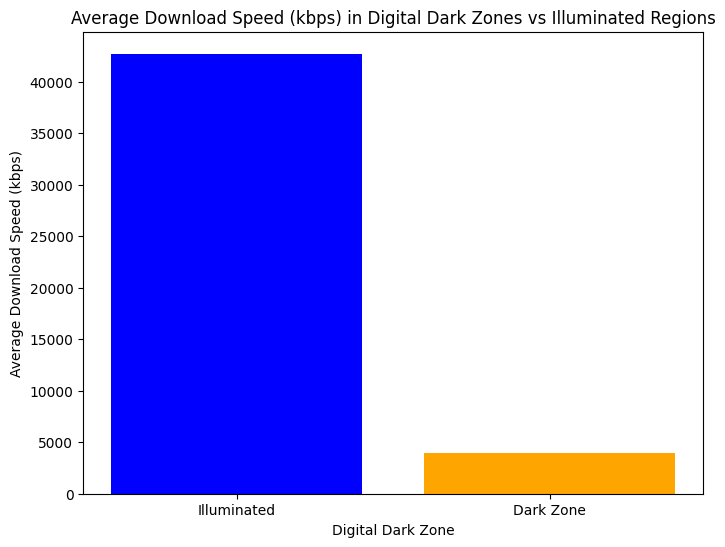

In [60]:
#3.	Bar Chart

grouped = df.groupby('digital_dark_zone')['avg_d_kbps'].mean().reset_index()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(grouped['digital_dark_zone'].astype(str), grouped['avg_d_kbps'], color=['blue', 'orange'])
plt.title('Average Download Speed (kbps) in Digital Dark Zones vs Illuminated Regions')
plt.xlabel('Digital Dark Zone')
plt.ylabel('Average Download Speed (kbps)')
plt.xticks([0, 1], ['Illuminated', 'Dark Zone'])
plt.show()

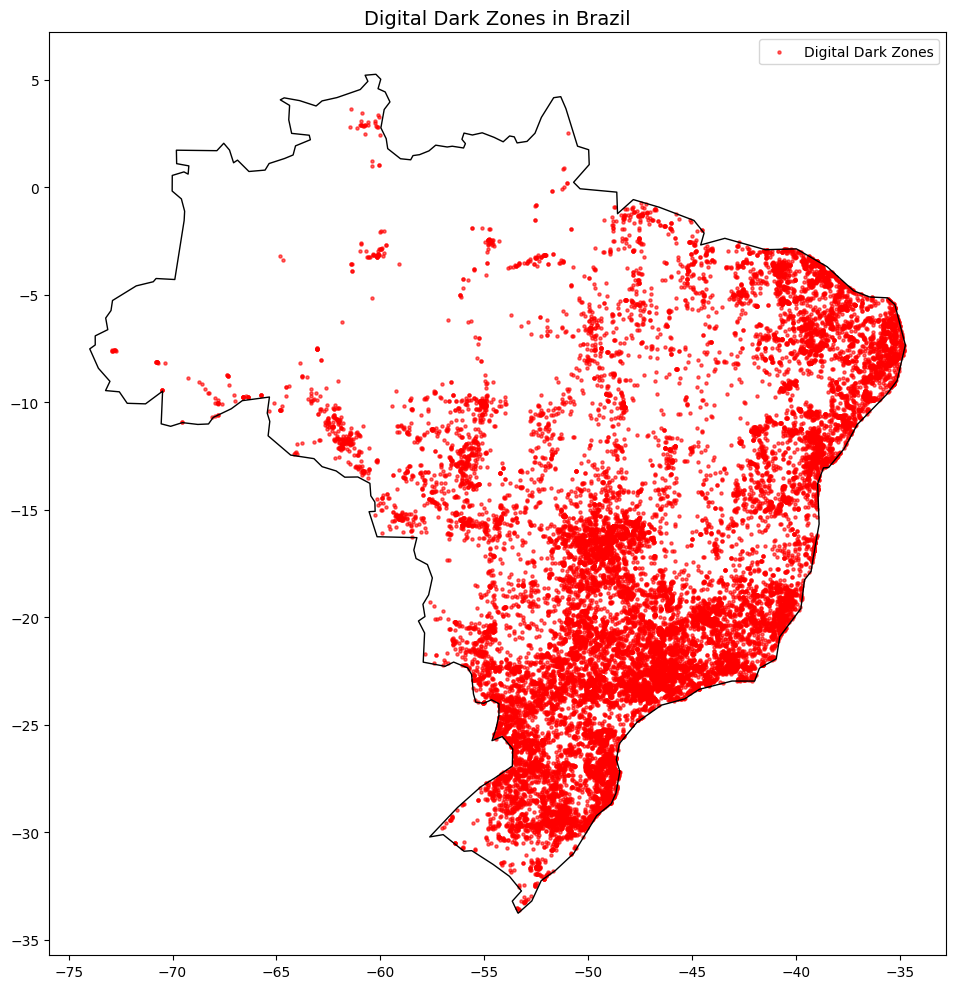

In [61]:
# 4.Geospatial Overla

# Load the shapefile
shapefile_path = "../110m_cultural/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

# Filter for Brazil
brazil = world[world['ADMIN'] == 'Brazil']

# Convert your DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Digital Dark Zones (red)
brazil.boundary.plot(ax=ax, color="black", linewidth=1)
gdf[gdf['digital_dark_zone']].plot(
    ax=ax, color="red", markersize=5, alpha=0.6, label="Digital Dark Zones"
)
ax.set_title("Digital Dark Zones in Brazil", fontsize=14)
ax.legend(fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

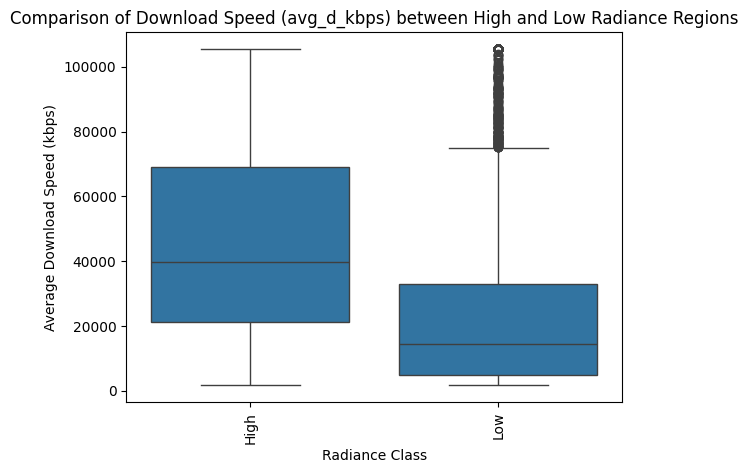

In [62]:
#5.	Boxplot

# Use a smaller sample for quick visualization
df_sample = df.sample(n=10000, random_state=42)

# Classify radiance into high and low categories using vectorized operations
median_radiance = df_sample['radiance_avg'].median()
df_sample['RadianceClass'] = ['High' if x > median_radiance else 'Low' for x in df_sample['radiance_avg']]

# Clip the values to remove extreme outliers
lower_bound = df_sample['avg_d_kbps'].quantile(0.05)
upper_bound = df_sample['avg_d_kbps'].quantile(0.95)
df_sample['avg_d_kbps'] = df_sample['avg_d_kbps'].clip(lower=lower_bound, upper=upper_bound)

# Plotting the comparison for avg_d_kbps without extreme outliers
base_color = sb.color_palette()[0]
sb.boxplot(data=df_sample, x='RadianceClass', y='avg_d_kbps', color=base_color)
plt.title('Comparison of Download Speed (avg_d_kbps) between High and Low Radiance Regions')
plt.xlabel('Radiance Class')
plt.ylabel('Average Download Speed (kbps)')
plt.xticks(rotation=90)
plt.show()

# Similarly, you can plot for other metrics like avg_u_kbps, avg_lat_ms, etc.